# EE4414 Lab Time_Series_Prediction_Optional

## Acknowledgment

This lab experiment is inspired by Usman Malik's Stack Abuse article.

You can check out the original post at https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python



## 1. Training a time series predictor

A time series data is a sequential data indexed in time order.
Often we would like to predict the future behaviour of a time series.
For example, we may be interested in predicting the weather, share prices, sales, etc. 
Long Short-Term Memory (LSTM) model can be applied to perform time series prediction. 

In this exercise, we will use the ``flights`` dataset from the seaborn library.
The dataset contains 3 columns: ``year``, ``month``, and ``passengers``.
Where the ``year`` and ``month`` columns refer to the particular year and month of the monthly flight record, respectively.
The ``passengers`` column records the total number of passengers that took the flights in that month.

We will do the following steps in order:

1) Load and normalize the training and testing datasets using ``StandardScalar``
   
2) Define an LSTM model

3) Define a loss function

4) Train the network on the training data

5) Test the network on the test data

In [1]:
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(0)
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 1. Loading the flights dataset


Loading the ``flights`` data from ``seaborn`` is strightforward.

In [4]:
import seaborn as sns

flights = sns.load_dataset('flights')
print(type(flights)) # the dataset is loaded as pandas dataframe
flights.describe(include = 'all')

# save the data as comma-separated values (csv) to facilitate viewing of the raw data
flights.to_csv('flights_data.csv', index=False)

<class 'pandas.core.frame.DataFrame'>



### 2. Visualizing the training data


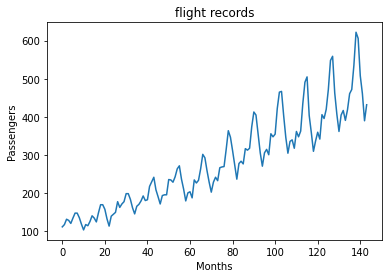

In [5]:
plt.plot(flights['passengers'])
plt.title('flight records')
plt.xlabel('Months')
plt.ylabel('Passengers')
plt.show()

### 3. Normalizing the data and converting to tensor

In a regression problem such as this, it is beneficial to normalize the data. It allows the model to converge faster and avoid having large losses. 

In [6]:
from sklearn.preprocessing import StandardScaler

passengers = flights['passengers'].values.astype(float) # convert the passengers column to float 
scaler = StandardScaler()
normalized_data = scaler.fit_transform(passengers.reshape(-1,1))

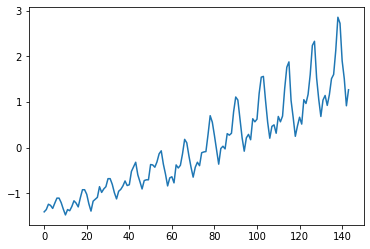

In [7]:
plt.plot(normalized_data)

### 4. Generating the sequences
Since we have 144 months (i.e., 12 years) of flight data, we use 132 months (i.e., 11 years) for training and the remaining 12 months (i.e., 1 year) for testing.

In [8]:
# create windowed sequence tuples of (x,y), with moving window of step size = 1
def windowed_sequences(data, window_size=12, test_size=12):
    x = []
    y = []
    for i in range(len(data)-window_size-test_size+1):
        j = i + window_size
        xi = data[i:j]
        yi = data[j]
        x.append(xi)
        y.append(yi)
    return x, y
        
test_size = 12
seqeunces, targets = windowed_sequences(normalized_data, 12, test_size)

 # Convert the sequences to float type tensors
train_x = torch.Tensor(seqeunces[:-1]).type(torch.float)
train_y = torch.Tensor(targets[:-1]).type(torch.float) 
test_seq = torch.Tensor(seqeunces[-1]).type(torch.float)

c:\Users\zheng\.conda\envs\FinRL\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)


### 5. Constructing the iterables

In [9]:
# Using pytorch data loading utility to construct iterable over the dataset

from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, x, y):
        super(CustomDataset, self).__init__()
        self.x = x
        self.y = y

    def __getitem__(self, item):
        return self.x[item],  self.y[item]

    def __len__(self):
        return len(self.x)
    
train_set = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_set, batch_size=24)

## Optional Exercise

So far we have considered different configurations for a single LSTM layer. 

Similar to the CNN, additional layers can be added to the LSTM to make the model deeper and adding levels of abstraction. This is achieved by stacking multilayers of LSTM on top of each other. 

In addition, on some sequential data problems, having the LSTM model learn the input sequences from both forward and backward directions can be beneficial. The backward direction LSTM processes the input in reverse chronological order. To consider both forward and backward information the hidden states from both directions are concatenated.

In this part, you will modify the network into a bidirectional multilayer LSTM.
Pytorch LSTM module has provided a convenient wrapper to facilitate the construction of bidirectional and multilayer LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
Note that the hidden states of the LSTM module may change according to the configurations (i.e., bidirectional would double the hidden state size at each layer). Tune the model to find the most suitable hyperparameters for your bidirectional multilayer LSTM.

### 6. Defining the bidirectional multilayer LSTM model (To do)

In [17]:
# class TimeSeriesPredictor(nn.Module):
#     def __init__(self, input_dim=1, hidden_dim=200, output_dim=1, num_layers=1):
#         super(TimeSeriesPredictor,self).__init__()
        
#         self.hidden_dim = hidden_dim
        
#         # To do
#         self.lstm = 
#         self.fc1 = 
#         self.fc2 = nn.Linear(100, output_dim)

#     def forward(self, input_seq):

#         lstm_out, (hn, cn) = self.lstm(input_seq)
#         # To do
#         hn = 
#         predictions = F.relu(self.fc1(hn))
#         predictions = self.fc2(predictions)
#         return predictions

    
import torch.nn as nn
import torch.nn.functional as F

class TimeSeriesPredictor(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=200, output_dim=1, num_layers=1):
        super(TimeSeriesPredictor, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # Define the bidirectional multilayer LSTM
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True)

        # Define the fully connected layers
        self.fc1 = nn.Linear(hidden_dim * 2, 100)  # Multiply by 2 for bidirectional
        self.fc2 = nn.Linear(100, output_dim)

    def forward(self, input_seq):
        lstm_out, (hn, cn) = self.lstm(input_seq)

        # Concatenate the hidden states from both directions
        #-2 is the index that gives the hidden states of the forward RNN, -1 is the index that gives the hidden states of the backward RNN
        #how hn tensor store as "[forward_1, backward_1, forward_2, backward_2, ..., forward_n,backward_n]"
        hn = torch.cat((hn[-2], hn[-1]), dim=1)

        predictions = F.relu(self.fc1(hn))
        predictions = self.fc2(predictions)
        return predictions


### 7. Initializing the network and optimizer

In [18]:
model = TimeSeriesPredictor(num_layers=2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001) # adapt to increased model complexity by lowering lr

### 8. Print the network structure

In [19]:
print(model)

TimeSeriesPredictor(
  (lstm): LSTM(1, 200, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=400, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=1, bias=True)
)


### 9. Initialize the training iterables

In [21]:
window_size = 12
test_size = 12
seqeunces, targets = windowed_sequences(normalized_data, window_size, test_size)
train_x = torch.Tensor(seqeunces[:-1]).type(torch.float)
train_y = torch.Tensor(targets[:-1]).type(torch.float)
test_seq = torch.Tensor(seqeunces[-1]).type(torch.float)

train_set = CustomDataset(train_x, train_y)
train_loader = DataLoader(train_set, batch_size=24)
test_seq = torch.Tensor(seqeunces[-1]).type(torch.float)

### 10. Training the network

In [22]:
model.to('cpu')
t1 = time.time()
loss_list = []
for epoch in range(1000):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        seq, labels = data
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    loss_list.append(running_loss/len(train_loader))
    if epoch % 100 == 99:
        print(f'epoch: {epoch+1:3} loss: {running_loss/len(train_loader):.4f}')

t2 = time.time()
print('Finished Training')
print('Training time:'+str(t2-t1))

epoch: 100 loss: 0.5435
epoch: 200 loss: 0.1363
epoch: 300 loss: 0.1255
epoch: 400 loss: 0.1084
epoch: 500 loss: 0.0826
epoch: 600 loss: 0.0568
epoch: 700 loss: 0.0341
epoch: 800 loss: 0.0266
epoch: 900 loss: 0.0232
epoch: 1000 loss: 0.0200
Finished Training
Training time:225.30954313278198


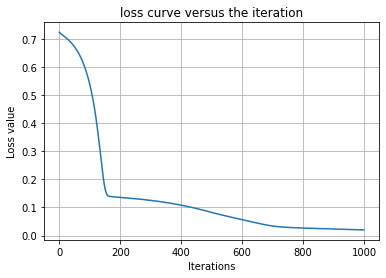

In [23]:
iterations = np.arange(len(loss_list))

fig, ax = plt.subplots()
ax.plot(iterations, loss_list)
ax.set(xlabel='Iterations', ylabel='Loss value',
       title='loss curve versus the iteration')
ax.grid()

plt.show()

### 11. Perform predictions

In [24]:
preds_bdml = []
with torch.no_grad():
    for i in range(test_size):
        outputs = model(test_seq.unsqueeze(dim=0)) # unsqueeze to add a dimension to accomodate the batch processing
        test_seq = torch.cat((test_seq,outputs),dim=0)[-12:]
        preds_bdml.append(outputs)

### 12. Evaluate performance

In [25]:
from sklearn.metrics import mean_absolute_percentage_error

denormalized_preds_bdml = scaler.inverse_transform(np.array(preds_bdml).reshape(-1, 1))
mape = mean_absolute_percentage_error(passengers[-test_size:], denormalized_preds_bdml)
print('MAPE: %.2f%%' % (mape*100))

MAPE: 3.77%


c:\Users\zheng\.conda\envs\FinRL\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\zheng\.conda\envs\FinRL\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package 

### 13. Plotting the results in the same plot (To do)

Plot the the ground truth (in black and label it as 'ground truth') and the bidirectional multilayer LSTM prediction (in green dotted line with x marker and label it as 'bdml').

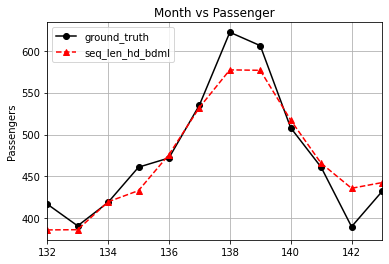

In [26]:
x_axis = np.arange(132, 144, 1)
plt.title('Month vs Passenger')
plt.ylabel('Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(x_axis,passengers[-test_size:], 'ko-', label='ground_truth')
plt.plot(x_axis,denormalized_preds_bdml, 'r^--', label='seq_len_hd_bdml')
plt.legend()
plt.show()